In [1]:
import os 
figure_folder = 'figures-v4'
os.makedirs(figure_folder, exist_ok=True)

n_ms_per_s= 1000
n_total_trial= 100

curation = {
    'M15_2': {
        # 'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15,16,20,21, 22, 23, 24, 29, 36, 44, 45, 48]),
        'CA1': (3.5, [1, 6, 7, 8, 9, 10, 11, 13, 15, 24, 29, 36, 44, 45, 48]),
        # Noisy 'M1': [], 
    }, 
    'M15_3': {
       'CA1': (3.5, [25, 29, 34]), 
        'M1': (3.5, [23, 24]), 

    }, 
    'M15_5': {
        'CA1': (3.5, [4, 5, 7, 8, 9, 10, 11, 12, 15, 21, 62, 66]),
        # 'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
        'M1': (3.5, [28, 29, 31, 33, 34,35, 36, 37, 38, 39, 40, 41, 43, 44]),
    }, 
    'M15_7': {
        'CA1': (3.5, [7, 11, 12, 13, 14, 19, 20]),
        # 'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 36,  37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
        'M1': (3.5, [4, 6, 10, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 30,31,  32,35, 37, 38, 41, 42, 44, 45, 46, 47,48,  51, 52, 53, 55, 56, 57, 58,59,62]),
    }, 
    'M16_1': {
        # 'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 22, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        'CA1': (3.5, [1, 2,3,  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 25, 26, 27, 29, 31, 32, 33, 35, 36, 37, 38, 54, 57, 58, 59, 60, 61, 62]),
        # Noisy 'M1': (), 
    },
}    

import os
import shutil 

for subject, subject_curation in curation.items():
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/curated/{region}'        
        os.makedirs(output_folder, exist_ok=True)

        for unit_id in curated_units:
            if not os.path.isfile(f'{output_folder}/{subject}-{threshold}-{unit_id}.png'):
                shutil.copy2(f'data/processed/{subject}/{region}/curations-{threshold}/{unit_id}.png', f'{output_folder}/{subject}-{threshold}-{unit_id}.png')

# Reaction Time

In [ ]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator


session_palette = {
    session_index + 1: color for session_index, color in enumerate(['#D1D9EC', '#a2b1d8', '#8597c6', '#697fb7', '#ffbcbb', '#ffb5b4', '#ffaeac', '#ffa6a5', '#e44e4b', '#d93f3c', '#cc3330', '#b03533', '#ddde29', '#bcbd21'])
}

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

reaction_times = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
        state_ids = np.where(events['state'] == 'state')[0]
        if len(state_ids) > 0:
            events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            events['x'] = pd.to_numeric(events['x'])
            events['y'] = pd.to_numeric(events['y'])
            events['time'] = pd.to_numeric(events['time'])
            events['state'] = pd.to_numeric(events['state'])
            events['trial'] = pd.to_numeric(events['trial'])
            events['s_trial'] = pd.to_numeric(events['s_trial'])
            events['f_trial'] = pd.to_numeric(events['f_trial'])

        events['x'] = analog_to_digital(events['x'])
        events['y'] = analog_to_digital(events['y'])
        events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
        events['time'] = events['time'] - events['time'][0]
        events['time'] = events['time'] / n_ms_per_s 

        for trial in range(n_total_trial):
            trial_indices = np.where(events['trial'] == trial)[0]
            if any(events['state'][trial_indices] == 1):
                trial_reaction_index = np.where((events['trial'] == trial) & (events['state'] == 1))[0][0]
                reaction_times.append({
                    'subject': subject,
                    'session': session_index+1,
                    'reaction': events['time'][trial_reaction_index] - events['time'][trial_indices.min()],
                })
        
reaction_times = pd.DataFrame(reaction_times)

In [ ]:
fig = plt.figure(figsize=(10, 15))
for session in range(1, reaction_times['session'].max()+1):
    ax = plt.subplot(len(reaction_times['session'].unique())+1, 1, session)
    sns.kdeplot(data=reaction_times[reaction_times['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
    ax.set_ylim(0, 0.28)
    ax.set_xlim(-3, 12)
    ax.set_ylabel(session)
    ax.set_yticks([])
    ax.set_axis_off()
ax.set_axis_on()
fig.suptitle(f'Reaction time distribution')
plt.savefig(f'{figure_folder}/reaction_density.pdf')
plt.show()
plt.close()

In [ ]:
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    stats = reaction_times[reaction_times['subject']==subject]
    fig = plt.figure(figsize=(10, 15))
    for session in range(1, stats['session'].max()+1):
        ax = plt.subplot(len(stats['session'].unique())+1, 1, session)
        sns.kdeplot(data=stats[stats['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
        ax.set_ylim(0, 0.15)
        ax.set_xlim(-3, 13)
        ax.set_ylabel(session)
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_axis_off()
    ax.set_axis_on()
    fig.suptitle(f'{subject} - Reaction time distribution')
    plt.savefig(f'{figure_folder}/{subject}_reaction_density.pdf')
    plt.show()
    plt.close()

# Success Rate

In [ ]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

In [ ]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

In [ ]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()

# Unit Raster Plots

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1

for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/raster-behavior/{region}'
        os.makedirs(output_folder, exist_ok=True)
        
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        for unit_id in tqdm(curated_units):
            unit_plot_file = f'{output_folder}/{subject}-{threshold}-{unit_id}.png'
            if os.path.isfile(unit_plot_file):
                continue
        
            cue_spike_trains, reward_spike_trains = [], []
            cue_train_counts, reward_train_counts = [], []
            
            for segment_index in range(n_segment):
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial
                
                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_cue_spike_trains, segment_reward_spike_trains = [], []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    # In this plots only successful trials have reaction time.
                    if trial not in s_trials: continue

                    t_cue_start = trial_start - s_before * sorting.sampling_frequency
                    t_cue_end = trial_start + s_after * sorting.sampling_frequency

                    cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                    cue_spike_train = cue_spike_train / sorting.sampling_frequency
                    segment_cue_spike_trains.append(cue_spike_train)

                    reward_time = int(trial_start + reaction_times[trial] * sorting.sampling_frequency)
                    t_reward_start = reward_time # - s_before * sorting.sampling_frequency
                    t_reward_end = reward_time + (s_before + s_after) * sorting.sampling_frequency

                    reward_spike_train = unit_spike_train[(unit_spike_train >= t_reward_start) & (unit_spike_train <= t_reward_end)] - reward_time
                    reward_spike_train = reward_spike_train / sorting.sampling_frequency
                    segment_reward_spike_trains.append(reward_spike_train)
                
                cue_spike_trains.extend(segment_cue_spike_trains)
                reward_spike_trains.extend(segment_reward_spike_trains)

                cue_train_counts.append(len(cue_spike_trains))
                reward_train_counts.append(len(reward_spike_trains))
                
            fig = plt.figure(figsize=(7, 6))
            fig.suptitle(f'{subject} - {region} - {unit_id}')
            ax = plt.subplot(1, 2, 1)
            ax.eventplot(cue_spike_trains)
            for segment_index, y in enumerate(cue_train_counts):
                ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
                ax.text(s_after+0.2, y, f'{segment_index+1}')
            ax.set_ylabel('trials')
            ax.set_title('relative to cue')
            ax.set_xticks([-1, 0, 1])
            ax.invert_yaxis()
            
            ax = plt.subplot(1, 2, 2)
            ax.eventplot(reward_spike_trains)
            for segment_index, y in enumerate(reward_train_counts):
                ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=0.5)
                ax.text(s_before+s_after+0.2, y, f'{segment_index+1}')
            ax.set_ylabel('trials')
            ax.set_title('relative to reward')
            ax.set_xticks([0, 1, 2])
            ax.invert_yaxis()

            plt.tight_layout()
            plt.savefig(unit_plot_file)#, transparent=True)
            # plt.show()
            plt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

# Unit Heatmap Plots

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 100

for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/heatmap-behavior-{bin_size_ms}ms/{region}'
        os.makedirs(output_folder, exist_ok=True)
        
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        for unit_id in tqdm(curated_units):
            unit_plot_file = f'{output_folder}/{subject}-{threshold}-{unit_id}.png'
            if os.path.isfile(unit_plot_file):
                continue
        
            spike_bins = []
        
            for segment_index in range(n_segment):
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial
                
                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_cue_spike_bins, segment_reward_spike_bins = [], []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    # In this plots only successful trials have reaction time.
                    if trial not in s_trials: continue

                    t_cue_start = trial_start - s_before * sorting.sampling_frequency
                    t_cue_end = trial_start + s_after * sorting.sampling_frequency

                    cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                    cue_spike_train = cue_spike_train / sorting.sampling_frequency
                    cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_cue_spike_bins.append(cue_spike_bin)

                    reward_time = int(trial_start + (reaction_times[trial] + 1) * sorting.sampling_frequency)
                    t_reward_start = reward_time # - s_before * sorting.sampling_frequency
                    t_reward_end = reward_time + (s_before + s_after) * sorting.sampling_frequency

                    reward_spike_train = unit_spike_train[(unit_spike_train >= t_reward_start) & (unit_spike_train <= t_reward_end)] - reward_time
                    reward_spike_train = reward_spike_train / sorting.sampling_frequency
                    reward_spike_bin = np.histogram(reward_spike_train, bins=np.arange(0, (s_before + s_after)+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_reward_spike_bins.append(reward_spike_bin)
                
                segment_cue_spike_bins = np.array(segment_cue_spike_bins)
                segment_reward_spike_bins = np.array(segment_reward_spike_bins)

                segment_bins = np.hstack([segment_cue_spike_bins, segment_reward_spike_bins])
                segment_bins = (segment_bins - segment_bins.mean()) / (segment_bins.std() + 1e-6)

                spike_bins.append(segment_bins.mean(0))
            

            spike_bins = np.array(spike_bins)
            cue_spike_bins = spike_bins[:, :spike_bins.shape[1] // 2]
            reward_spike_bins = spike_bins[:, spike_bins.shape[1] // 2:]

            vlim = 0.5
            fig = plt.figure(figsize=(10, 6))
            fig.suptitle(f'{subject} - {region} - {unit_id}')
            ax = plt.subplot(1, 2, 1)
            sns.heatmap(cue_spike_bins, cmap=plt.cm.bwr, vmin=-vlim, vmax=vlim)
            ax.set_ylabel('sessions')
            ax.set_title('relative to cue')
            ax.set_xticks([0, cue_spike_bins.shape[1]//2, cue_spike_bins.shape[1]], [-s_before, 0, s_after])

            ax = plt.subplot(1, 2, 2)
            sns.heatmap(reward_spike_bins, cmap=plt.cm.bwr, vmin=-vlim, vmax=vlim)
            ax.set_ylabel('sessions')
            ax.set_title('relative to reward')
            ax.set_xticks([0, reward_spike_bins.shape[1]//2, reward_spike_bins.shape[1]], [0, (s_before+s_after)//2, (s_before+s_after)])

            plt.tight_layout()
            plt.savefig(unit_plot_file)#, transparent=True)
            # plt.show()
            plt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

# Unit PSTH

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 100

for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    for region, (threshold, curated_units) in subject_curation.items():
        output_folder = f'{figure_folder}/PSTH-behavior-{bin_size_ms}ms/{region}'
        os.makedirs(output_folder, exist_ok=True)
        
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        for unit_id in tqdm(curated_units):
            unit_plot_file = f'{output_folder}/{subject}-{threshold}-{unit_id}.png'
            # if os.path.isfile(unit_plot_file):
            #     continue
        
            spike_bins = []
        
            for segment_index in range(n_segment):
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial
                
                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_cue_spike_bins, segment_reward_spike_bins = [], []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    # In this plots only successful trials have reaction time.
                    if trial not in s_trials: continue

                    t_cue_start = trial_start - s_before * sorting.sampling_frequency
                    t_cue_end = trial_start + s_after * sorting.sampling_frequency

                    cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                    cue_spike_train = cue_spike_train / sorting.sampling_frequency
                    cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_cue_spike_bins.append(cue_spike_bin)

                    reward_time = int(trial_start + (reaction_times[trial] + 1) * sorting.sampling_frequency)
                    t_reward_start = reward_time # - s_before * sorting.sampling_frequency
                    t_reward_end = reward_time + (s_before + s_after) * sorting.sampling_frequency

                    reward_spike_train = unit_spike_train[(unit_spike_train >= t_reward_start) & (unit_spike_train <= t_reward_end)] - reward_time
                    reward_spike_train = reward_spike_train / sorting.sampling_frequency
                    reward_spike_bin = np.histogram(reward_spike_train, bins=np.arange(0, (s_before + s_after)+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_reward_spike_bins.append(reward_spike_bin)
                
                segment_cue_spike_bins = np.array(segment_cue_spike_bins)
                segment_reward_spike_bins = np.array(segment_reward_spike_bins)

                segment_bins = np.hstack([segment_cue_spike_bins, segment_reward_spike_bins])

                spike_bins.append(segment_bins.mean(0))
            

            spike_bins = np.array(spike_bins)
            cue_spike_bins = spike_bins[:, :spike_bins.shape[1] // 2]
            reward_spike_bins = spike_bins[:, spike_bins.shape[1] // 2:]

            fig = plt.figure(figsize=(6, 10))
            fig.suptitle(f'{subject} - {region} - {unit_id}')
            ax = plt.subplot(4, 2, 1)
            # for segment_index in range(n_segment):
            #     # sns.lineplot(cue_spike_bins[segment_index], cmap=plt.cm.bwr, vmin=-vlim, vmax=vlim)
            #     ax.plot(cue_spike_bins[segment_index], color='black', alpha=0.1)
            ax.plot(cue_spike_bins.mean(0), color='black')
            ax.set_ylabel('firing counts')
            ax.set_title('relative to cue')
            ax.set_xticks([0, cue_spike_bins.shape[1]//2, cue_spike_bins.shape[1]], [-s_before, 0, s_after])

            ax = plt.subplot(4, 2, 2)
            # for segment_index in range(n_segment):
            #     ax.plot(reward_spike_bins[segment_index], color='black', alpha=0.1)
            ax.plot(reward_spike_bins.mean(0), color='black')
            ax.set_ylabel('firing counts')
            ax.set_title('relative to reward')
            ax.set_xticks([0, reward_spike_bins.shape[1]//2, reward_spike_bins.shape[1]], [0, (s_before+s_after)//2, (s_before+s_after)])

            for segment_index in range(n_segment):
                ax = plt.subplot(20, 2, 2*(segment_index+5)+1)
                ax.plot(cue_spike_bins[segment_index])
                ax.set_xticks([0, cue_spike_bins.shape[1]//2, cue_spike_bins.shape[1]], [-s_before, 0, s_after])
                ax.set_ylabel(f'{segment_index+1}')
                ax.set_yticks([])
                ax.set_xticks([])
                
                ax = plt.subplot(20, 2, 2*(segment_index+5)+2)
                ax.plot(reward_spike_bins[segment_index])
                ax.set_xticks([0, reward_spike_bins.shape[1]//2, reward_spike_bins.shape[1]], [0, (s_before+s_after)//2, (s_before+s_after)])
                ax.set_ylabel(f'{segment_index+1}')
                ax.set_yticks([])
                ax.set_xticks([])

            plt.savefig(unit_plot_file)#, transparent=True)
            # plt.show()
            plt.close()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Overall heatmap

In [2]:
import numpy as np
import pandas as pd
import pickle
import spikeinterface.core as sc 
import spikeinterface.curation as scu
import spikeinterface.extractors as se

from tqdm.auto import tqdm 

n_segment = 14
n_ms_per_s = 1000
s_before, s_after = 1, 1
bin_size_ms = 100

densities = {}
for subject, subject_curation in curation.items():
    session_info = pd.read_csv(f'data/processed/{subject}/info.csv')
    
    for region, (threshold, curated_units) in subject_curation.items():
        recordings = [sc.load_extractor(f'data/processed/{subject}/{region}/recordings/segment{segment_index}') for segment_index in range(n_segment)]
        recording = sc.concatenate_recordings(recordings)

        sorting = se.NpzSortingExtractor(f'data/processed/{subject}/{region}/sortings-{threshold}/sorter_output/firings.npz')
        sorting = scu.remove_excess_spikes(sorting, recording)
        sortings = sc.split_sorting(sorting, recordings)
        sortings = [sc.select_segment_sorting(sortings, segment_indices=segment) for segment in range(len(recordings))]

        n_frames_per_ms = int(sorting.sampling_frequency / n_ms_per_s)

        for unit_id in tqdm(curated_units):        
            spike_bins = []
        
            for segment_index in range(n_segment):
                segment_info = session_info[session_info['segment_index'] == segment_index]

                controller_date = segment_info['segment_path'].item().split('_')[-2]
                controller_date = controller_date[2:] + controller_date[:2]
                controller_file = f'data/raw/controller/{controller_date}/{subject.replace("_", "-")}.TXT'
                events = pd.read_csv(controller_file)
                # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
                state_ids = np.where(events['state'] == 'state')[0]
                if len(state_ids) > 0:
                    events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
                    
                s_trials, f_trials = [], []
                reaction_times = {} # in ms
                for trial in range(n_total_trial):
                    trial_indices = np.where(events['trial'] == trial)[0]
                    if any(events['state'][trial_indices] == 1):
                        s_trials.append(trial)
                        # The first index having "triggered state" (1) and event trial number marks the reacted time.
                        reaction_time = events['time'].tolist()[np.where((events['state'] == 1) & (events['trial'] == trial))[0][0]]
                        # Off set the reaction time to the start of the trial.
                        reaction_time -= events['time'].tolist()[trial_indices.min()]
                        reaction_times[trial] = reaction_time / n_ms_per_s
                    else:
                        f_trials.append(trial)
                assert len(s_trials) + len(f_trials) == n_total_trial
                
                trial_starts = eval(segment_info['trial_starts'].item())
                trial_ends = eval(segment_info['trial_ends'].item())

                unit_spike_train = sortings[segment_index].get_unit_spike_train(unit_id)

                segment_cue_spike_bins, segment_reward_spike_bins = [], []
                for trial, (trial_start, trial_end) in enumerate(zip(trial_starts, trial_ends)):
                    # In this plots only successful trials have reaction time.
                    if trial not in s_trials: continue

                    t_cue_start = trial_start - s_before * sorting.sampling_frequency
                    t_cue_end = trial_start + s_after * sorting.sampling_frequency

                    cue_spike_train = unit_spike_train[(unit_spike_train >= t_cue_start) & (unit_spike_train <= t_cue_end)] - trial_start
                    cue_spike_train = cue_spike_train / sorting.sampling_frequency
                    cue_spike_bin = np.histogram(cue_spike_train, bins=np.arange(-s_before, s_after+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_cue_spike_bins.append(cue_spike_bin)

                    reward_time = int(trial_start + (reaction_times[trial] + 1) * sorting.sampling_frequency)
                    t_reward_start = reward_time # - s_before * sorting.sampling_frequency
                    t_reward_end = reward_time + (s_before + s_after) * sorting.sampling_frequency

                    reward_spike_train = unit_spike_train[(unit_spike_train >= t_reward_start) & (unit_spike_train <= t_reward_end)] - reward_time
                    reward_spike_train = reward_spike_train / sorting.sampling_frequency
                    reward_spike_bin = np.histogram(reward_spike_train, bins=np.arange(0, (s_before + s_after)+1e-6, bin_size_ms/n_ms_per_s))[0]
                    segment_reward_spike_bins.append(reward_spike_bin)
                
                segment_cue_spike_bins = np.array(segment_cue_spike_bins)
                segment_reward_spike_bins = np.array(segment_reward_spike_bins)

                segment_bins = np.hstack([segment_cue_spike_bins, segment_reward_spike_bins])
                segment_bins = (segment_bins - segment_bins.mean()) / (segment_bins.std() + 1e-6)

                spike_bins.append(segment_bins.mean(0))
            
            spike_bins = np.array(spike_bins)
            cue_spike_bins = spike_bins[:, :spike_bins.shape[1] // 2]
            reward_spike_bins = spike_bins[:, spike_bins.shape[1] // 2:]

            densities[(subject, region, unit_id)] = {
                'cue': cue_spike_bins,
                'reward': reward_spike_bins,
            }
            
# Open a file in write mode
with open(f'{figure_folder}/densities.pickle', 'wb') as file:
    # Serialize and save the object to the file
    pickle.dump(densities, file)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [5]:
densities[('M15_2', 'CA1', 1)]['cue'].shape

(14, 20)

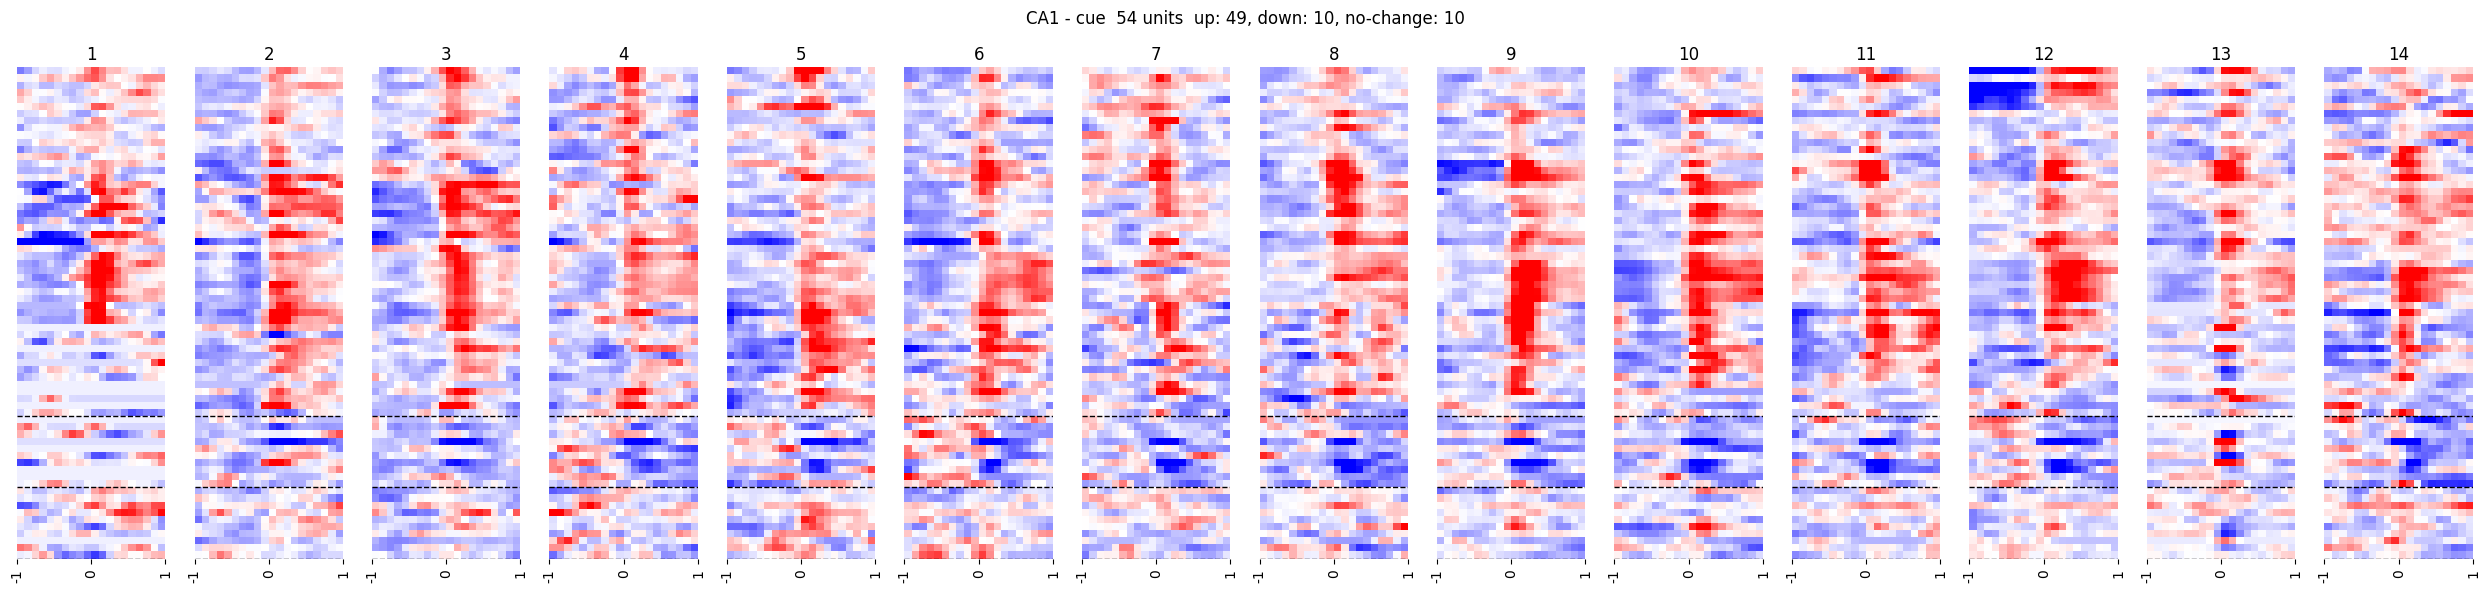

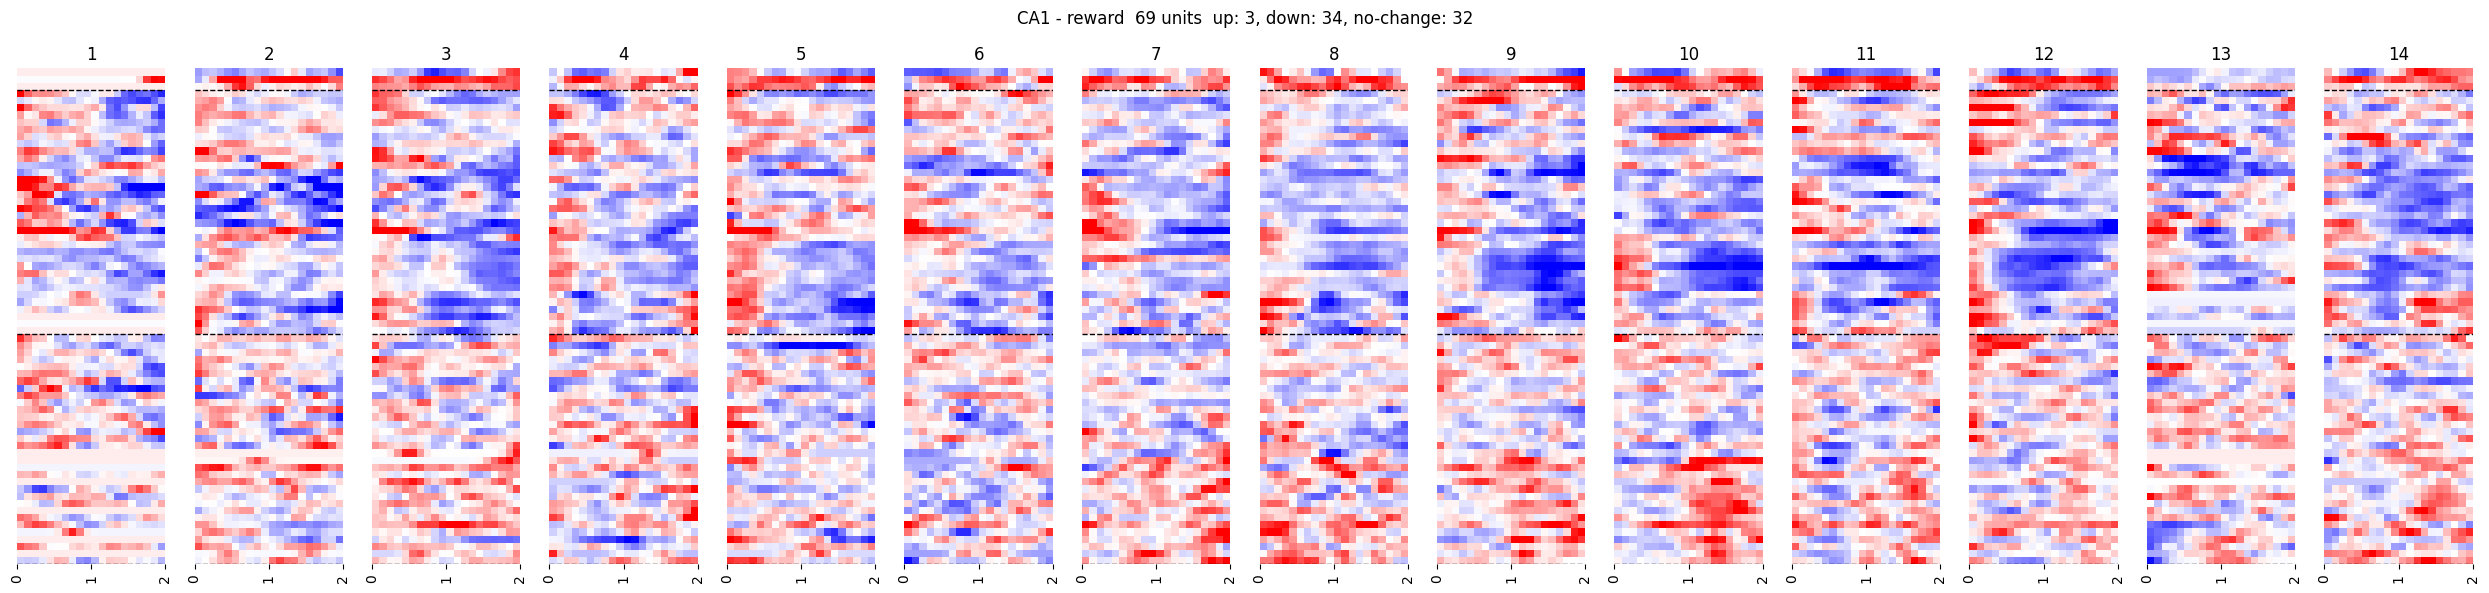

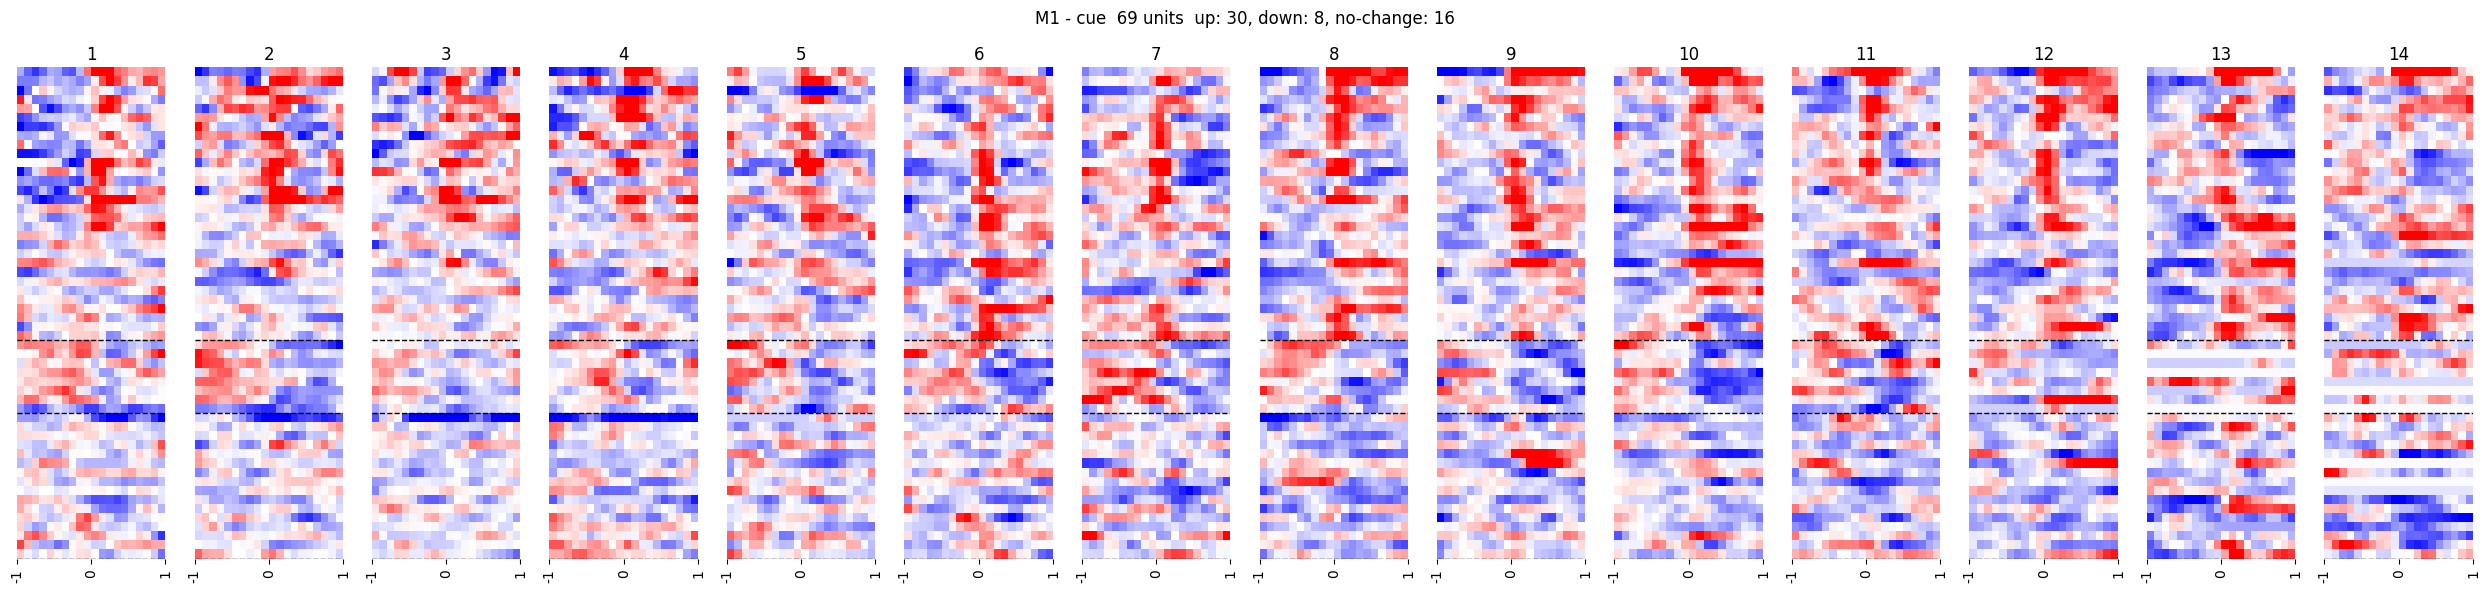

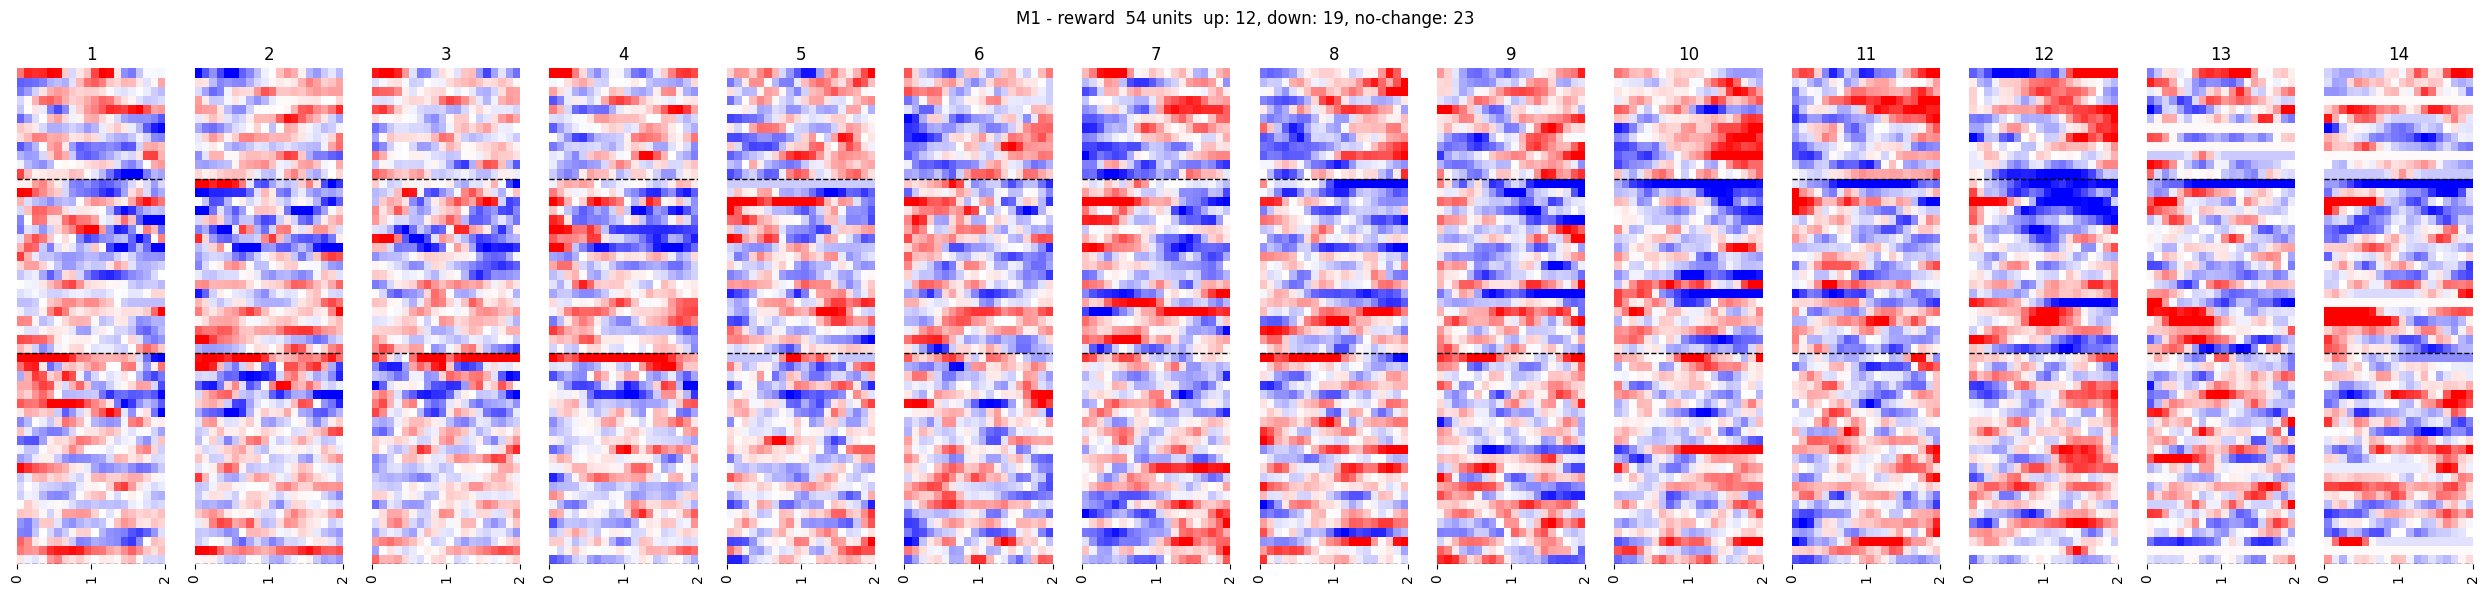

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from scipy.ndimage import gaussian_filter1d

react_units = {
    'cue':{
        'CA1': {
            'up': {
                'M15_2': [1, 10, 11, 13, 15, 24, 29, 44, 45, 48, 6, 7, 9],
                'M15_3': [25, 29, 34],
                'M15_5': [11, 12, 15, 21, 4, 5, 62, 66, 7, 9],
                'M15_7': [11, 12, 13, 14, 19, 20, 7],
                'M16_1': [1, 10, 11, 13, 14, 2, 3, 36, 5, 57, 59, 6, 60, 7, 8, 9],
            },
            'down': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [],
                'M16_1': [25, 26, 32, 33, 37, 38, 54, 58, 61, 62],
            },
        },
        'M1': {
            'up': {
                'M15_2': [],
                'M15_3': [23],
                'M15_5': [28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
                'M15_7': [10, 17, 18, 19, 21, 30, 37, 4, 41, 46, 48, 51, 53, 57, 6],
                'M16_1': [],
            },
            'down': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [42, 44, 45, 52, 55, 56, 58, 59],
                'M16_1': [],
            },
        },
    },
    'reward': {
        'CA1': {
            'up': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [],
                'M15_7': [],
                'M16_1': [33, 5, 58],
            },
            'down': {
                'M15_2': [1, 13, 15, 24, 48, 6, 7, 8, 9],
                'M15_3': [25, 29, 34],
                'M15_5': [11, 15, 21, 4, 5, 62, 66, 8, 9],
                'M15_7': [11, 12, 13, 14, 19, 20, 7],
                'M16_1': [1, 10, 2, 3, 36, 8],
            },
        },
        'M1': {
            'up': {
                'M15_2': [],
                'M15_3': [],
                'M15_5': [38], 
                'M15_7': [14, 15, 24, 30, 36, 42, 44, 51, 52, 56, 57, 58],
                'M16_1': [],
            },
            'down': {
                'M15_2': [],
                'M15_3': [23],
                'M15_5': [28, 29, 31, 33, 34, 40, 44],
                'M15_7': [10, 19, 21, 22, 29, 32, 37, 4, 41, 53, 6],
                'M16_1': [],
            },
        },
    },
}

# Open the file in read mode
with open(f'{figure_folder}/densities.pickle', 'rb') as file:
    # Deserialize and load the object from the file
    loaded_densities = pickle.load(file)

vlims = {
    'CA1': 1.8,
    'M1': 1.5,
}
n_segment = 14
conditions = ['cue', 'reward']

for plot_region in ['CA1', 'M1']:
    for condition in conditions:
        plot_file = f'{figure_folder}/{plot_region}-{condition}_heatmap.pdf'
        # if os.path.isfile(plot_file): continue
    
        typed_bins = {
            'up': [],
            'down': [],
            'no-change': [],
        }
        for (subject, region, unit_id), bins in loaded_densities.items():
            if region != plot_region: continue
            if unit_id in react_units[condition][region]['up'][subject]:
                label = 'up'
            elif unit_id in react_units[condition][region]['down'][subject]:
                label = 'down'
            else:
                label = 'no-change'
            typed_bins[label].append(bins[condition]) 

        unit_counts = [0]
        for label, label_bins in typed_bins.items():
            unit_counts.append(unit_counts[-1] + len(label_bins))
        unit_counts = unit_counts[1:]

        fig = plt.figure(figsize=(25, 6))
        fig.suptitle(f'{plot_region} - {condition}  {len(segment_bins)} units  ' + ', '.join([f'{label}: {len(label_bins)}' for label, label_bins in typed_bins.items()]))
        for segment_index in range(n_segment):
            ax = plt.subplot(1, n_segment, segment_index+1)  
            segment_bins = []
            for label, label_bins in typed_bins.items():
                segment_bins.append(np.array(label_bins)[:, segment_index])
            segment_bins = np.vstack(segment_bins)
            segment_bins = (segment_bins - segment_bins.mean()) / (segment_bins.std() + 1e-6)
            segment_bins = gaussian_filter1d(segment_bins, 1)
            sns.heatmap(segment_bins, cmap=plt.cm.bwr, ax=ax, vmin=-vlims[plot_region], vmax=vlims[plot_region], cbar=False)
            ax.set_yticks([])
            for type_index, y in enumerate(unit_counts):
                ax.axhline(y=y, color='black', linestyle='--', alpha=1, linewidth=1)

            ax.set_title(f'{segment_index+1}')
            ax.set_xticks([0, 10, 20], [-1, 0, 1] if condition == 'cue' else [0, 1, 2])
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show() 
        plt.close()